## Introduction

> Here we take the prepared data from the previous book and try and answer, by applying various models, prediction of cancellation of booking.

> This cancellation prediction based on criteria defined in the most optimal features, will help, hotel management to  avoid loss or revenue due to cancellation. The output of this book will help hotels manage inventory, staffing, suppy chain, operations improvement and many other areas in order to stay profitable.

important commands
> - Shift + Enter (executes cell)
> - Alt + Enter (executes and creates new cell)
> - Esc + Shift + Up/Down (expands selection)
> - Up/Down (moves cells up/down)

> Esc + M (converts cell to markup)
> Esc + Y (converts cell to code)
> Esc + H (shows all commands)

> Underscore twice (converts to bold)
> Astrisk once (convrets to italics)


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import warnings
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Model Analysis

Apply model analysis to prepared data from Data Prep notebook.

# is_cancelled Prediction


In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from matplotlib.lines import Line2D
import seaborn as sns
from tqdm import tqdm
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier


## Load prepared data from Snapshots

In [3]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold

X_train_norm_clf_pca = pd.read_pickle('X_train_norm_clf_pca.pkl')
X_test_norm_clf_pca = pd.read_pickle('X_test_norm_clf_pca.pkl')
y_train_clf = pd.read_pickle('y_train_clf.pkl')
y_test_clf = pd.read_pickle('y_test_clf.pkl')
X_train_norm_clf_pca.head()

y_test_clf.head()

model_scores = []

vc_best_estimator_input = []


# Define Functions for score calculations and graph plotting

In [2]:
def calc_metrics(y, y_pred):
    metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
    scores = [fn(y, y_pred) for fn in metrics]
    model_scores.append(scores)
    return scores

def display_scores(y, y_pred):
    model_scores_names = ['accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'roc_auc_score']
    scores = calc_metrics(y, y_pred)
    for idx in range(len(model_scores_names)):
        print(model_scores_names[idx], ":", scores[idx])

def plot_precision_recall_vs_threshold(y, y_pred):
    precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.figure(figsize=(8, 4))

    
def plot_roc_curve(y, y_pred, label=None):
    fpr, tpr , thresholds = roc_curve(y, y_pred)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.figure(figsize=(8, 6))
    
def plot_accurracy_prec_roc(model_scores, model_names):
    N = 3
    ind = np.arange(N)  # the x locations for the groups
    width = 0.27       # the width of the bars

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111) 
    ax2 = ax.twinx() 
    ax3 = ax.twinx()
    labels = model_names
    acc_score = []
    prec_score = []
    rec_score = []

    for idx in range(len(model_scores)):
        md_scores = model_scores[idx]
        acc_score.append(md_scores[0])
        prec_score.append(md_scores[1])
        rec_score.append(md_scores[2])

    acc_score = pd.DataFrame(acc_score)
    prec_score = pd.DataFrame(prec_score)
    rec_score = pd.DataFrame(rec_score)

    acc_score[:].plot(kind='bar', color='red', ax=ax, width=0.1, position=1, legend=None)
    prec_score[:].plot(kind='bar', color='yellow', ax=ax2, width=0.1, position=3, legend=None)
    rec_score[:].plot(kind='bar', color='blue', ax=ax3, width=0.1, position=2, legend=None)
    ax.set_xlabel('Models')
    ax.set_xticklabels(model_names, rotation=0)
    ax.set_ylabel('Accuracy')
    ax2.set_ylabel('Precision, recall')
    #ax3.set_ylabel('Recall')
    legend_elements = [
    Line2D([0], [0], marker='s', color='r', label='Accuracy',markerfacecolor='r', markersize=8,linestyle='-'),
    Line2D([0], [0], marker='s', color='b', label='Recall',markerfacecolor='b', markersize=8, linestyle='-'),
    Line2D([0], [0], marker='s', color='y', label='Precision',markerfacecolor='y', markersize=8, linestyle='-')]
    ax.legend(handles=legend_elements, loc='top-right')
    plt.show()
    
    
model_names = ['KNeighborsClassifier','LogisticRegression', 'RandomForestClassifier','SVC','DecisionTreeClassifier']

warnings.filterwarnings('ignore')


# Models and Tuning

In [5]:
KNNclf = KNeighborsClassifier(n_neighbors = 2)
KNNclf_params = {"weights": ["uniform", "distance"], "n_neighbors": [2,5,10]}

forestclf = RandomForestClassifier(n_estimators = 10, bootstrap="true", random_state = 42)
forerstclf_params = {"criterion": ["gini"], "n_estimators": [10,20,50]}

decisionclf = DecisionTreeClassifier()
decisionclf_params = {"criterion": ["gini"]}

logclf = LogisticRegression(solver="liblinear", random_state=42)
logclf_params = {"solver":["liblinear", "lbfgs"],"penalty":["l2"], "tol":[0.0001,0.001], "C":[1.0,2.0]}

svmclf = SVC(gamma="auto", random_state=42)
svmclf_params = {"kernel":["rbf", "sigmoid"], "tol":[0.0001,0.001], "C":[1.0,2.0]}


models = [(KNNclf, KNNclf_params), (logclf,logclf_params), (forestclf, forerstclf_params), (svmclf, svmclf_params), (decisionclf, decisionclf_params)]

for idx, model in enumerate(models):
    model_name = str(model[0])
    print(model_name)
    grid = GridSearchCV(estimator = model[0], param_grid = model[1], cv = 3)
    grid.fit(X_train_norm_clf_pca, y_train_clf)
    y_pred = grid.predict(X_test_norm_clf_pca)
    display_scores(y_test_clf, y_pred)
    #print(model_names[idx])
    vc_best_estimator_input.append((model_names[idx] , grid.best_estimator_))
    print(vc_best_estimator_input)

    

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')
accuracy_score : 0.8336282087096875
precision_score : 0.7934562130699356
recall_score : 0.7488139825218477
f1_score : 0.7704889954611629
roc_auc_score : 0.8164424332963659
[('KNeighborsClassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance'))]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy_score : 0.7945494614644443
precision_score : 0.7861081654294804
recall_score : 0.616978

In [6]:
vc_best_estimator_input
ms_df = pd.DataFrame(model_scores)
ms_df.to_pickle("classifier_model_scores.pk1")

[('KNeighborsClassifier',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                       metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                       weights='distance')),
 ('LogisticRegression',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                     warm_start=False)),
 ('RandomForestClassifier',
  RandomForestClassifier(bootstrap='true', class_weight=None, criterion='gini',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=50,
       

# VotingClassifier with Best Estimators from GridSearchCV

In [7]:
voting_clf = VotingClassifier(estimators=vc_best_estimator_input, voting='hard')

In [8]:
voting_clf.fit(X_train_norm_clf_pca, y_train_clf)
y_pred = voting_clf.predict(X_test_norm_clf_pca)

In [9]:
display_scores(y_test_clf, y_pred)

accuracy_score : 0.86258807461899
precision_score : 0.8746050552922591
recall_score : 0.7372451102788181
f1_score : 0.800072257598338
roc_auc_score : 0.8371900237068777


In [10]:
conmat = confusion_matrix(y_pred,y_test_clf)

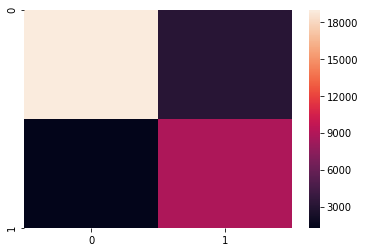

In [11]:
sns.heatmap(conmat)

# Persist final results

In [14]:
ms_df.to_pickle("classifier_model_scores.pk1")

In [4]:
ms_df = pd.read_pickle("classifier_model_scores.pk1")

In [5]:
model_names.append('VotingClassifier')

In [7]:
ms_df['model_names'] = model_names

# Final Results

In [8]:
ms_df.columns = ['Accuracy Score', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score','Model Name']
ms_df.head(6)

,Accuracy Score,Precision,Recall,F1 Score,ROC AUC Score,Model Name
0,0.833628,0.793456,0.748814,0.770489,0.816442,KNeighborsClassifier
1,0.794549,0.786108,0.616979,0.691350,0.758569,LogisticRegression
2,0.864109,0.877509,0.738743,0.802169,0.838706,RandomForestClassifier
3,0.816650,0.828387,0.641199,0.722871,0.781098,SVC
4,0.813515,0.745565,0.758968,0.752207,0.802462,DecisionTreeClassifier
5,0.862588,0.874605,0.737245,0.800072,0.837190,VotingClassifier


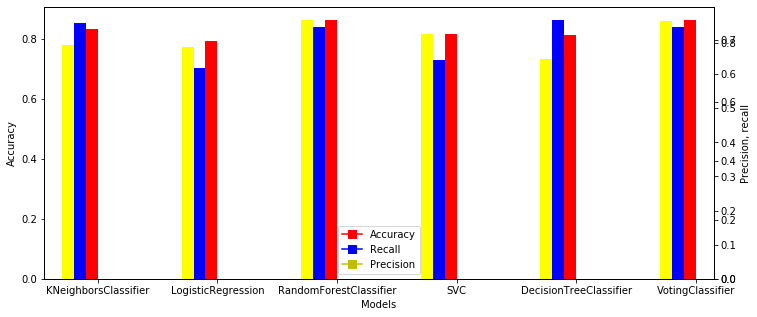

In [11]:
plot_accurracy_prec_roc(ms_df.values, model_names)

# Conclusion

> We conclude, given the circumstances of features and within the boundaries of the operating environment of this notebook, VotingClassifier and RandomForestClassifier and the two best methods to provide cancellation prediction.

>However, given the nature and operating mode of VotingClassifier, we believe that with

> - Accuracy_score  : 0.86258807461899 
> - Precision_score : 0.8746050552922591
> - Recall_score    : 0.7372451102788181

>VotingClassifier is the best method to predict Cancellation of reservation in this dataset.
